In [243]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [245]:
def l1_norm(x: np.ndarray) -> float:
    """ Computes the L1 norm 

        Args:
            x: A 1D or 2D column vector 

        Return:
            A float corresponding to the L1 norm
    """
    return float(np.sum(np.abs(x)))

In [247]:
def squared_l2_norm(x: np.ndarray) -> float:
    """ Computes the squared L2 norm 

        Args:
            x: A 1D or 2D column vector 

        Return:
            A float corresponding to the squared L2 norm
    """
    
    return float(np.sum(np.square(x)))

In [249]:
bike_df = pd.read_csv("train.csv")

In [252]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


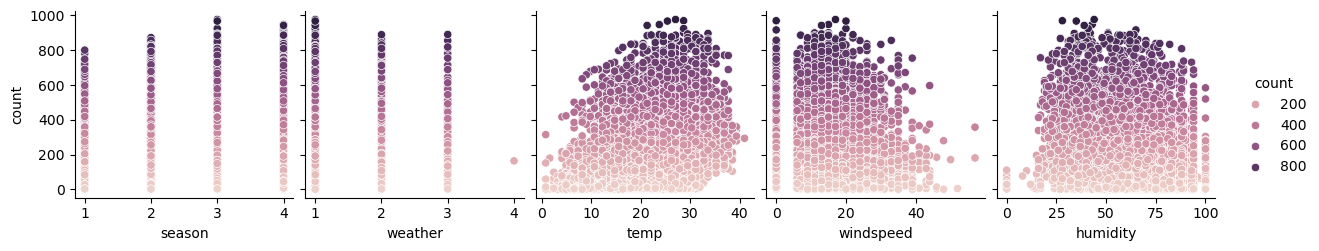

In [486]:
import seaborn as sb
rng = np.random.RandomState(1)
indices = rng.choice(np.arange(len(bike_df)), size = len(bike_df), replace=False)

sb.pairplot(
    bike_df.iloc[indices],
    x_vars=["season","weather", "temp", "windspeed", "humidity",],
    y_vars=["count",],
    hue="count",
)
plt.show()

In [482]:
#-----------------------Season----------------------------------
# 1 = spring, 2 = summer, 3 = fall, 4 = winter

#---------------------- Weather -------------------------------- 
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [280]:
def poly_features(X: np.ndarray, degree: int) -> np.ndarray:
    """ Compute polynomial features for pass data

        Args:
            X: Matrix of input data for which polynomial features
                will be computed for.

            degree: The degree of the polynomial which will be computed.

        Return:
            A matrix containing the original data and the new polynomial data.
    """
   
    if degree == 1:
        return X
        
    X_poly = X

    for i in range(2, degree + 1):
        X_poly = np.hstack((X_poly, X ** i))

    
    
    return X_poly

In [326]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
) -> Tuple[np.ndarray]:
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= None, None, None, None, None, None

    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state= 42)

    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.2, random_state= 42)
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [328]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_data(degree: int)  -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training, validation, and testing

        Args:
            degree: The degree to use when computing polynomial features. 
        
        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X = bike_df.drop(['count', 'datetime'], axis=1).values
    y = bike_df['count'].values


    X_poly  = poly_features(X, degree)
    
    

    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X_poly, y)
    

    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn) 
    X_vld = scaler.transform(X_vld)      
    X_tst = scaler.transform(X_tst) 
    
    

    X_trn = np.hstack([np.ones((X_trn.shape[0], 1)), X_trn])
    X_vld = np.hstack([np.ones((X_vld.shape[0], 1)), X_vld])
    X_tst = np.hstack([np.ones((X_tst.shape[0], 1)), X_tst])

    # Reshape targets to be 2D column vectors
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [330]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [533]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [535]:
class RidgeLeastMeanSquares():
    """ Performs ridge regression using least mean squares (gradient descent)
    
        Attributes:

            alpha: learning rate or step size

            lamb (float): Regularization parameter for controlling
                L2 regularization.
                
            batch_size: Size of mini-batches for mini-batch gradient
                descent.
            
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: 1D vector of weights 

            trn_error: Stores the training error for each epoch.

            vld_error: Stores the validation error for each epoch.
    """

    def __init__(
        self, 
        alpha: float,
        lamb: float, 
        batch_size: int,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.lamb = lamb
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_error = None
        self.vld_error = None
    
    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Train LMS to learn weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        # Set seed for reproducibility
        np.random.seed(self.seed)
        # Track training/validation error
        self.trn_error = []
        self.vld_error = []

        self.w = np.random.rand(X.shape[1], 1)

        lamb = np.ones_like(self.w)
        lamb[0] = 0
        
        for e in range(self.epochs):
            batches = get_batches(X.shape[0], self.batch_size)
            
            # Loop over batched data indices
            for i in batches:
                # TODO 7.3
                xb = X[i]  
                yb = y[i]
                
                mean_grad = np.dot(xb.T, (np.dot(xb, self.w) - yb)) / xb.shape[0]
                reg = self.lamb * lamb * self.w
                self.w -= self.alpha * (mean_grad + reg)
                
            # Compute training/validation error for current epoch
                trn_preds = self.predict(X)
                trn_error = rmse(y, trn_preds)
                self.trn_error.append(trn_error)

                if X_vld is not None and y_vld is not None:
                    vld_preds = self.predict(X_vld)
                    vld_error = rmse(y_vld, vld_preds)
                    self.vld_error.append(vld_error)
            
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        
        return np.dot(X, self.w)

Testing RMSE: 5.976926825281296, Iterations: 0


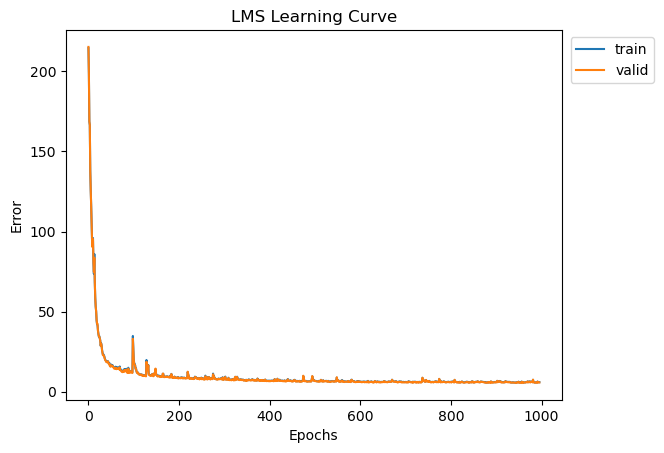

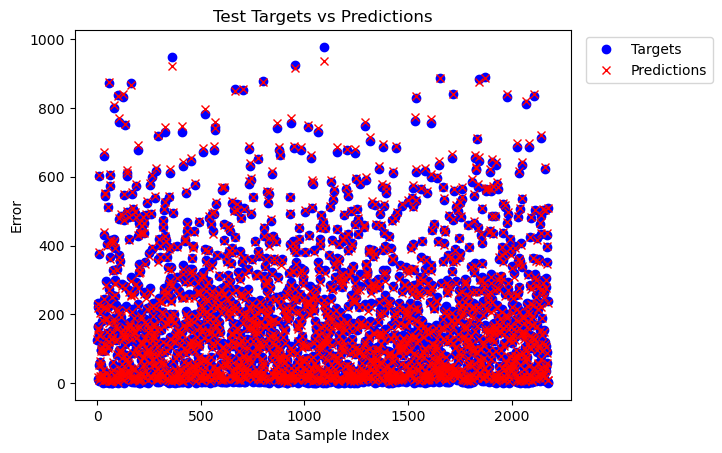

In [542]:
# Get training and testing data

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data(
    degree = 5
)



for i in range(1): 
    rlms = RidgeLeastMeanSquares(
            lamb=0.0155,
            alpha= 0.1,
            batch_size=42, 
            epochs=6,
            seed=42
        )

# Tracker for Lowest comb, lamb=.0.00255,alpha=.1, batch_size=42, epochs=304,seed=42

    rlms.fit(X_trn, y_trn, X_vld, y_vld)
    
    y_hat_tst = rlms.predict(X_tst)
    
    tst_mse = mse(y_tst, y_hat_tst)
    tst_rmse = rmse(y_tst, y_hat_tst)
    

    print(f"Testing RMSE: {tst_rmse}, Iterations: {i}")





### Plotting Code ###
# Plot learning curve
plt.plot(rlms.trn_error, label='train')
plt.plot(rlms.vld_error, label='valid')
plt.title("LMS Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(bbox_to_anchor=(1.2, 1.00))
plt.show()

# Plot test targets and predictions
plt.plot(y_tst, 'ob', label='Targets')
plt.plot(y_hat_tst, 'xr', label='Predictions')
plt.xlabel("Data Sample Index")
plt.ylabel("Error")
plt.title("Test Targets vs Predictions")
plt.legend()
plt.legend(bbox_to_anchor=(1.3, 1.00))
plt.show()

### Display Weights ###
# print(f"Weights:\n{rlms.w.flatten()}")